# Loading and visualizing groundwater models

This exercise, we will load an existing model into Flopy, run the model and then use [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/) and [numpy](https://www.numpy.org/) to look at the results and compare them to observed data. We will also export model input and output to shapefiles and rasters.

#### Operations
* reading tabular data from a file or url using the powerful [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method
* geting `pandas.DataFrame`s of Hydmod, SFR, and global mass balance output
* converting model times to real date-times to allow plotting against other temporally-referenced data
* quickly subsetting data by category, attribute values, times, index position, etc.
* computing quantiles and other basic statistics
* making plots using `matplotlib` and the built-in hooks to it in `pandas`
* GIS and PDF export, and making a summary table with the [`modflow-export`](https://github.com/aleaf/modflow-export) package

#### The Little Plover River example
The example model is a TMR inset of the Little Plover River model set in central WI, which is documented by Bradbury and others (2017). The parent model files and report are avaible [here](https://wgnhs.wisc.edu/little-plover-river-groundwater-model/). The TMR inset encompasses the Little Plover River down to the Hoover Ave. bridge in Plover, WI, and the calendar year of 2014. Unconfined groundwater flow in the underlying glacial outwash, and base flow in the Little Plover River are simulated. Constant heads are used for the perimeter boundaries. The properties are mostly the same as the parent model.

![](data/lpr_inset/figs/lpr_inset.png)


**Reference:**
Bradbury, K.R., Fienen, M.N., Kniffin, M.L., Krause, J.J., Westenbroek, S.M., Leaf, A.T., and Barlow, P.M., 2017, Groundwater flow model for the Little Plover River basin in Wisconsin’s Central Sands: Wisconsin Geological and Natural History Survey Bulletin 111, 82 p.

In [1]:
import os
import flopy
fm = flopy.modflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

flopy is installed in C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\flopy


In [2]:
plt.rcParams['figure.figsize'] = (11, 8.5)

### inputs

In [3]:
namefile = 'lpr_inset.nam'
model_ws = 'data/lpr_inset/'
listingfile = '{}/lpr_inset.list'.format(model_ws)
gagefile = '{}/5400625lpr.ggo'.format(model_ws)
start_datetime = '2014-01-01'

gage_data_url = 'https://nwis.waterdata.usgs.gov/wi/nwis/uv?&format=rdb&site_no=05400625&period=&begin_date=2014-01-01&end_date=2014-12-31'

### outputs

In [4]:
output_folder = os.path.join(model_ws, 'postproc')

### load the model

In [5]:
m = fm.Modflow.load(namefile, model_ws=model_ws)
m.get_package_list()

['DIS', 'BAS6', 'UPW', 'RCH', 'OC', 'SFR', 'GAGE', 'WEL', 'HYD', 'NWT', 'CHD']

In [6]:
m

MODFLOW 3 layer(s) 137 row(s) 171 column(s) 12 stress period(s)

### plot the K field in layer 1

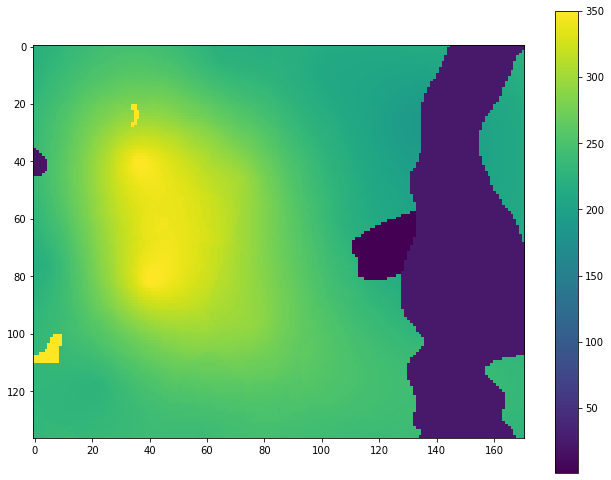

In [7]:
plt.imshow(m.upw.hk.array[0], vmax=350)
plt.colorbar()

### plot recharge for the model period
convert from feet per day to annual inches

In [8]:
m.rch.rech.array.shape

(12, 1, 137, 171)

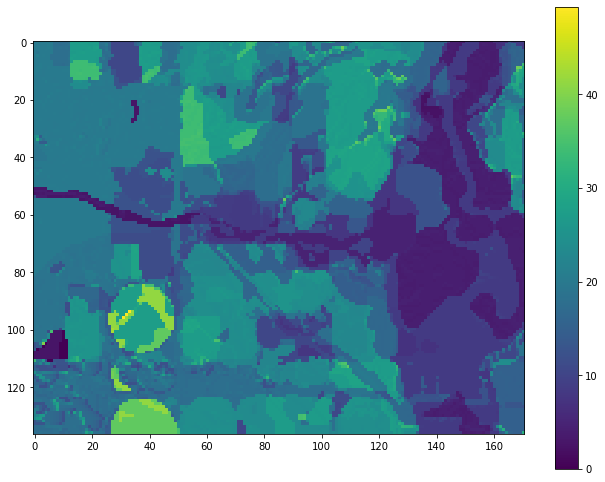

In [9]:
r_in = m.rch.rech.array[:, 0, :, :] * 12
plt.imshow(r_in.sum(axis=0) * 30.4)
plt.colorbar()

### spatial mean of recharge through time
convert from feet per day to average monthly totals (in inches) for model area

<BarContainer object of 12 artists>

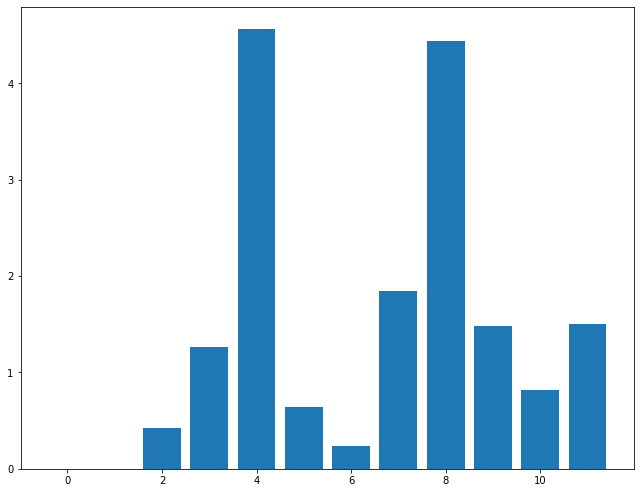

In [10]:
plt.bar(range(12), r_in.mean(axis=(1, 2)) * 30.4)

### set the executable

on Windows: `../bin/mfnwt.exe`

In [13]:
m.exe_name = '../../executables/mfnwt'

In [14]:
m.run_model()

FloPy is using the following  executable to run the model: ../../executables/mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: lpr_inset.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/11/21 13:57:35

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.

(True, [])

## Looking at results using pandas

#### loading the gage file using `read_csv`

In [15]:
ggo = pd.read_csv(gagefile, skiprows=1, header=None, delim_whitespace=True, names=['time', 'stage', 'flow'])

In [16]:
ggo.head()

,time,stage,flow
0,4.165770,1076.4440,386562.19
1,9.164696,1076.4413,352201.69
2,15.163405,1076.4233,324042.84
3,22.361858,1076.4089,301068.38
4,31.000000,1076.3965,281124.16


#### convert times in gage output to real date times

In [17]:
start_ts = pd.Timestamp(start_datetime)
start_ts

Timestamp('2014-01-01 00:00:00')

In [18]:
pd.to_timedelta(ggo.time, unit='D').head()

0    4 days 03:58:42.571199
1    9 days 03:57:09.708480
2   15 days 03:55:18.192000
3   22 days 08:41:04.531200
4          31 days 00:00:00
Name: time, dtype: timedelta64[ns]

In [19]:
ggo['datetime'] = pd.to_timedelta(ggo.time, unit='D') + start_ts
ggo.index = ggo.datetime
ggo.head()

,time,stage,flow,datetime
datetime,,,,
2014-01-05 03:58:42.571199999,4.165770,1076.4440,386562.19,2014-01-05 03:58:42.571199999
2014-01-10 03:57:09.708480000,9.164696,1076.4413,352201.69,2014-01-10 03:57:09.708480000
2014-01-16 03:55:18.192000000,15.163405,1076.4233,324042.84,2014-01-16 03:55:18.192000000
2014-01-23 08:41:04.531200000,22.361858,1076.4089,301068.38,2014-01-23 08:41:04.531200000
2014-02-01 00:00:00.000000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000000


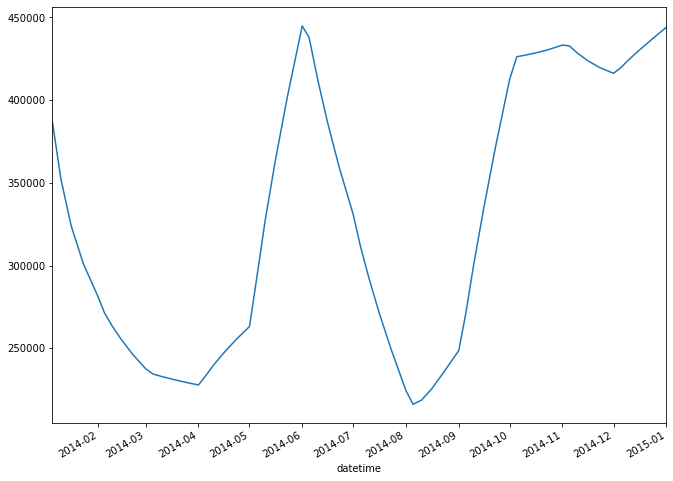

In [20]:
ggo.flow.plot()

### What if we only want to plot flow results for the last timestep of each stress period?

#### make lists of the period and timestep at each row in the gage package output

In [21]:
m.dis.nstp.array

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [22]:
kstp = []
kper = []
for i, nstp in enumerate(m.dis.nstp.array):
    for j in range(nstp):
        kstp.append(j)
        kper.append(i)
len(kstp)

60

In [23]:
ggo['kstp'] = kstp
ggo['kper'] = kper
ggo.head()

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-01-05 03:58:42.571199999,4.165770,1076.4440,386562.19,2014-01-05 03:58:42.571199999,0,0
2014-01-10 03:57:09.708480000,9.164696,1076.4413,352201.69,2014-01-10 03:57:09.708480000,1,0
2014-01-16 03:55:18.192000000,15.163405,1076.4233,324042.84,2014-01-16 03:55:18.192000000,2,0
2014-01-23 08:41:04.531200000,22.361858,1076.4089,301068.38,2014-01-23 08:41:04.531200000,3,0
2014-02-01 00:00:00.000000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000000,4,0


### Get the last timesteps using `groupby`

In [24]:
ggo_last = ggo.groupby(ggo.kper).last()
ggo_last.index = ggo_last.datetime
ggo_last

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-02-01 00:00:00.000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000,4,0
2014-02-28 23:59:59.654400,58.999996,1076.3673,237598.88,2014-02-28 23:59:59.654400,4,1
2014-04-01 00:00:00.691200,90.000008,1076.3594,227836.64,2014-04-01 00:00:00.691200,4,2
2014-05-01 00:00:01.728000,120.000020,1076.3799,263181.75,2014-05-01 00:00:01.728000,4,3
2014-06-01 00:00:01.728000,151.000020,1076.4760,444835.56,2014-06-01 00:00:01.728000,4,4
2014-07-01 00:00:01.728000,181.000020,1076.4280,330844.44,2014-07-01 00:00:01.728000,4,5
2014-08-01 00:00:01.728000,212.000020,1076.3630,224378.22,2014-08-01 00:00:01.728000,4,6
2014-09-01 00:00:01.728000,243.000020,1076.3694,248576.53,2014-09-01 00:00:01.728000,4,7
2014-10-01 00:00:00.000000,273.000000,1076.4595,412836.53,2014-10-01 00:00:00.000000,4,8


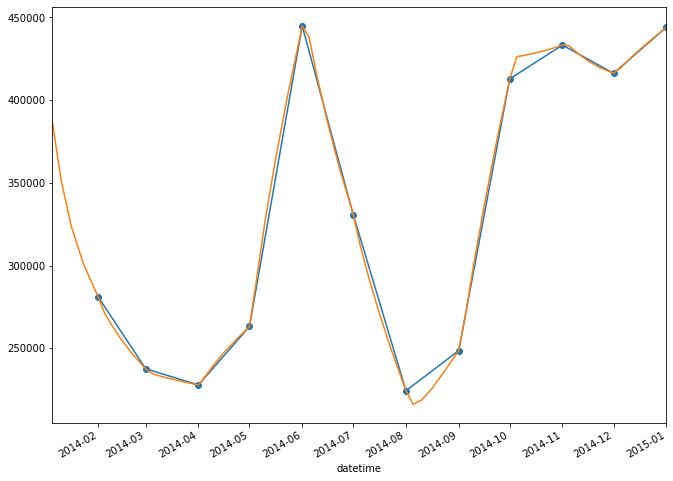

In [25]:
ax = ggo_last.flow.plot(marker='o')
ggo.flow.plot(ax=ax)

Some Flopy utilities can return model results in DataFrames.

### Get model mass balance information from the listing file

In [ ]:
from flopy.utils import MfListBudget

In [ ]:
mfl = MfListBudget('{}/{}.list'.format(model_ws, m.name))

In [ ]:
df_flux, df_vol = mfl.get_dataframes(start_datetime='01-01-2014')

In [ ]:
df_flux.head()

### plot some of the components against gage output

If we want to have more control over a plot, it often makes sense to use `matplotlib.pyplot` instead of the `DataFrame.plot()` methods.

In [ ]:
nbars = 2
width = 1/(nbars+2)
xvalues = np.arange(12)+1

fig, axes = plt.subplots(2, 1)
ax = axes.flat[0]
ax.bar(xvalues-width, -df_flux.WELLS_OUT, width=width, label='pumping', color='C1')
ax.bar(xvalues, df_flux.RECHARGE_IN, width=width, label='recharge', color='C0', alpha=0.5)
ax.bar(xvalues+width, df_flux.CONSTANT_HEAD_IN, width=width, label='constant head in', color='C2')
ax.bar(xvalues+width, -df_flux.CONSTANT_HEAD_OUT, width=width, label='constant head out', color='DarkGreen')

ax2 = axes.flat[1]
ax2.plot(xvalues, ggo_last.flow/86400)
ax.legend(bbox_to_anchor=(1., 1.05))

### Compare gage output to actual gage data from the web

In [ ]:
gage_data_url

### get data for site 5400625 in rdb format, using `read_csv`

or to use an already-downloaded text file, substitute `'../data/lpr_inset/05400625.txt'` for `gage_data_url`

In [ ]:
df = pd.read_csv(gage_data_url, skiprows=30, header=None, sep='\t')
df.head()

In [ ]:
'data/lpr_inset/05400625.txt'

### convert times to pandas datetimes

flow values are in column 4 in cubic feet per second

In [ ]:
df.index = pd.to_datetime(df[2])
df.head()

### convert monthly gage package results to cfs

In [ ]:
ggo_last['flow_cfs'] = ggo_last['flow'] / 86400
ggo_last.head()

In [ ]:
ax = ggo_last.flow_cfs.plot()
df[4].plot()

### convert gage results to monthly averages for flows less than q threshold

align timestamps with gage results

In [ ]:
qthresh = 0.5
quant = df[4].quantile(qthresh)
quant

In [ ]:
df[4].loc[df[4] < quant].plot()

In [ ]:
dfq = df[4].loc[df[4] < quant]
dfm = dfq.groupby(dfq.index.month).mean()
dfm

### create end of month times for monthly gage data averages so they plot with gage package output

In [ ]:
start_ts

In [ ]:
pd.date_range('2014-03', '2014-12', freq='M')

In [ ]:
dfm.index = pd.date_range('2014-03', '2015-01', freq='M')
dfm

In [ ]:
ax = ggo_last.flow_cfs.plot(label='gage output')
dfm.plot(ax=ax, label='data for 05400625')
ax.legend()

In [ ]:
dfm

In [ ]:
ggo_last

## Hydmod

In [ ]:
from flopy.utils import HydmodObs

In [ ]:
hydobj = HydmodObs('{}/{}.hyd.bin'.format(m.model_ws, m.name))
hyd = pd.DataFrame(hydobj.get_data())
hyd.head()

## Look at SFR water balance output (time pending)

In [ ]:
from flopy.utils import SfrFile

In [ ]:
sfrobj = SfrFile('{}/{}.sfr.out'.format(m.model_ws, m.name))

### get dataframe of SFR results

In [ ]:
sfrdata = sfrobj.df.copy()

In [ ]:
sfrdata.head()

### plot the groundwater/surfacewater interactions for a segment

get the distance information from the SFR package input

In [ ]:
seg11 = sfrdata.loc[(sfrdata.segment == 11) & (sfrdata.kstpkper == (4, 6)), ['Qout', 'Qaquifer']]

# get the reach data for SFR package
rd = pd.DataFrame(m.sfr.reach_data)
rd.head()

In [ ]:
dist = rd.loc[rd.iseg == 11, 'rchlen'].cumsum().tolist()
dist[0:10]

In [ ]:
seg11.index = dist

In [ ]:
ax = seg11.plot()
ax.axhline(0, color='k', zorder=-1, lw=0.5)

### make a quick and dirty map of groundwater/surface water interactions

In [ ]:
arr = np.zeros((m.nrow, m.ncol), dtype=float) * np.nan

i = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'i']
j = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'j']
qgw = sfrdata.loc[sfrdata.kstpkper == (4, 6), 'Qaquifer']
arr[i, j] = qgw

In [ ]:
plt.imshow(arr)
plt.colorbar()

In [ ]:
losing = arr.copy()
losing[losing <= 0] = np.nan
gaining = arr.copy()
gaining[gaining >= 0] = np.nan
im = plt.imshow(losing, cmap='Reds')
im2 = plt.imshow(gaining, cmap='Blues_r')
plt.colorbar(im)
plt.colorbar(im2)

## Exporting to gis file formats or PDFs

Flopy object instances have `.export()` methods at the model, package and array level. For example, to export the model top array from the DIS package:

In [ ]:
m.dis.export('{}/lpr_dis.shp'.format(output_folder))

By default, the `.export()` methods use the `modelgrid` attribute (attached to the Flopy model instance ) to locate the grid in space. By default, the `modelgrid` is built from information in the namefile header:

In [ ]:
with open(os.path.join(m.model_ws, m.namefile)) as src:
    for i in range(2):
        print(next(src))

This looks fine. However, when we look at the shapefile that was just exported, we can see that the origin (lower left corner) is correct, but the model extent is too large. This is because the model has length units of feet, while the `epsg:3070` coordinate reference system has length units of meters. **The current version of `Grid` in flopy is designed to mirror the discretization in the DIS package, and does not perform any length conversions on export to a CRS that is in meters**. To work around this, we can make a stand-alone instance of `StructuredGrid` with the spacing converted to meters:

In [ ]:
from flopy.discretization import StructuredGrid

grid = StructuredGrid(xoff=557570.748, yoff=441990.238, proj4='epsg:3070', 
                      delr=np.ones(m.ncol)*30.48, delc=np.ones(m.nrow)*30.48)

#### export just the top array, with a stand-alone grid

In [ ]:
m.dis.top.export('{}/lpr_top.shp'.format(output_folder), grid=grid)

We can export the whole model as well, but it takes a while, and puts everything into a single shapefile

In [ ]:
#m.export('{}/lpr.shp'.format(output_folder))

## Demo of modflow-export package
The goal of [modflow-export](https://github.com/aleaf/modflow-export) is easy export of MODFLOW datasets to GIS file formats and summary tables. It is still in early development. Both MODFLOW-NWT and MODFLOW-6 formats are supported, but only with structured grids.

In [ ]:
import mfexport

The grid for Little Plover River example is described in a JSON file (basically a serialized python dictionary):

In [ ]:
with open('data/lpr_inset/lpr_grid.json') as src:
    print(src.read())

In [ ]:
grid = mfexport.load_modelgrid('data/lpr_inset/lpr_grid.json')

#### set an output path

In [ ]:
output_path='data/lpr_inset/postproc'

### Export the whole model to PDFs, shapefiles and rasters
* `mfexport.export` returns a list of the files written
* Note that array-type data are written to GeoTiffs, while list-type data are written to shapefiles

In [ ]:
mfexport.export(m, grid, output_path=output_path, pdfs=True, gis=True)

#### Export just the DIS package

In [ ]:
mfexport.export(m, grid, packages='dis', output_path=output_path)

#### export just the top array from the DIS package

In [ ]:
mfexport.export(m, grid, packages='dis', variables='top', output_path=output_path)

### Create a summary table of the model input
* mfexport.summarize returns a dataframe, which can easily be dumped to a CSV file via [`DataFrame.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html)

In [ ]:
df = mfexport.summarize(m)
df

## Exporting model results

#### Heads
`mfexport.export_heads` writes both a GeoTiff of head values, and a shapefile of iso-contours, for each layer, at specified stress periods (`kstpkper` argument). It also writes a GeoTiff and shapefile of the simualted water table (which may cut through multiple layers).

In [ ]:
headsfile = '{}/lpr_inset.hds'.format(m.model_ws)

mfexport.export_heads(headsfile, grid, hdry=m.upw.hdry, hnflo=m.bas6.hnoflo,
                      kstpkper=(4, 0),
                      output_path=output_path)

### Export results from the SFR package

In [ ]:
mf2005_sfr_outputfile = '{}/lpr_inset.sfr.out'.format(m.model_ws)
outfiles = mfexport.export_sfr_results(mf2005_sfr_outputfile=mf2005_sfr_outputfile,
                                       model=m,
                                       grid=grid,
                                       kstpkper=(4, 0),
                                       output_length_units='feet',
                                       output_time_units='seconds',
                                       output_path=output_path,
                                       pointsize=2
                                       )